# ML Final Project

## Project Title
**When AI Meets Fashion: Multiclass Trend Prediction Using Fashion-MNIST**

In [27]:
# import all the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [28]:
# list of some helper functions
def load_data():
    training_data_path = "fashion-mnist_train.csv"
    testing_data_path = "fashion-mnist_test.csv"
    ourdata_path = "fashion_mnist_ourdata.csv"

    # preparing train test data
    train_csv = pd.read_csv(training_data_path, header=None, skiprows=1)
    test_csv = pd.read_csv(testing_data_path, header=None, skiprows=1)
    ourdata_csv = pd.read_csv(ourdata_path, header=None, skiprows=1)
    X_train, y_train = train_csv.iloc[:, 1:], train_csv.iloc[:, 0].astype(int)
    X_test, y_test = test_csv.iloc[:, 1:], test_csv.iloc[:, 0].astype(int)
    X_our, y_our = ourdata_csv.iloc[:, 1:], ourdata_csv.iloc[:, 0].astype(int)

    # Append our own data to training set
    X_train = pd.concat([X_train, X_our], ignore_index=True)
    y_train = pd.concat([y_train, y_our], ignore_index=True)

    return (np.asarray(X_train)[:10000],
            np.asarray(y_train)[:10000],
            np.asarray(X_test)[:1000],
            np.asarray(y_test)[:1000])

def sigmoid(x):
    # Clip to prevent overflow
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

In [29]:

class PCA:
    def __init__(self, X, num_components=None): #X = input data, num_components = dimensions to keep
        self.num_components = num_components

        # compute mean of each feature
        self.mn = np.mean(X, 0, keepdims=True)

        # de-mean the features (subtract mean from each sample)
        X_m = X - self.mn

        # compute covariance matrix
        covmat = X_m.T @ X_m/(len(X)-1)

        # compute eigenvalues and eigenvectors
        evals,evects = np.linalg.eigh(covmat)

        # sort by decreasing variance (largest eigenvalue = direction of max var)
        idx = np.argsort(evals)[::-1]
        self.evals = evals[idx]
        self.evects = evects[:,idx]

        # keep only the first n_components if given
        if num_components is not None:
            self.evals = self.evals[:num_components]
            self.evects = self.evects[:, :num_components]

    def transform(self,X):
        # center the data and project onto the principal components
        X_m = X - self.mn
        return X_m @ self.evects

    def num_effective_dims(self,percvar): # gives number of PCs needed for X% variance
        total_var = np.sum(self.evals)
        cumulative_vals = 100 * np.cumsum(self.evals) / total_var
        i = np.searchsorted(cumulative_vals, percvar)
        return i + 1



In [30]:
class BinaryLogisticRegression:
    """Simple Binary Class classification for 2 classes"""
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.mean = None
        self.std = None

    def fit(self, X, y):
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0) + 1e-8  # Add epsilon to avoid division by zero

        X_norm = (X - self.mean) / self.std
        n, d = X_norm.shape

        # Initialize weights
        w = np.zeros(d)

        for _ in range(self.epochs):
            p = sigmoid(X_norm @ w)
            grad = (X_norm.T @ (p - y)) / n
            w -= self.lr * grad

            #  if gradient is close to zero, stop
            if np.linalg.norm(grad) < 1e-6:
                break
        self.w_ = w
        return self

    def predict_probability(self, X):
        X_norm = (X - self.mean) / self.std
        return sigmoid(X_norm @ self.w_)

    def predict(self, X, threshold=0.5):
        return (self.predict_probability(X) >= threshold).astype(int)

class MulticlassLogisticRegression:
    """
    use one vs rest startegy for Multiclass classification.
    This is slow for real time analysis. We will prefer the softmax version.
    """
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.classifiers_ = []

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y = np.asarray(y)
        for c in self.classes_:
            clf = BinaryLogisticRegression(self.lr, self.epochs)
            # Create binary labels
            y_binary = (y == c).astype(float)
            clf.fit(X, y_binary)
            self.classifiers_.append(clf)
        return self

    def predict(self, X):
        probas = np.stack([clf.predict_probability(X) for clf in self.classifiers_], axis=1)
        return self.classes_[np.argmax(probas, axis=1)]


In [31]:
class LogisticRegression:
    """Better multiclass classification using softmax regression; Similar to multinomial logistic regression"""
    def __init__(self, lr=0.01, epochs=10000, tol=1e-6):
        self.lr = lr
        self.epochs = epochs
        self.tol = tol

    def softmax(self, x):
        z = x - np.max(x, axis=1, keepdims=True)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y)

        n_samples, n_features = X.shape
        classes, y_idx = np.unique(y, return_inverse=True)
        n_classes = len(classes)
        self.classes_ = classes

        # Normalization
        self.mean = X.mean(axis=0)
        std = X.std(axis=0)
        self.std = np.where(std == 0, 1e-8, std)
        X = (X - self.mean) / self.std

        # y matrix
        Y = np.eye(n_classes, dtype=np.float64)[y_idx]

        # Weights
        self.W = np.zeros((n_features, n_classes), dtype=np.float64)

        # Gradient Descent
        for _ in range(self.epochs):
            probs = self.softmax((X @ self.W))
            grad = (X.T @ (probs - Y)) / n_samples

            # updating the weights
            self.W -= self.lr * grad

            if np.linalg.norm(grad) < self.tol:
                break

        return self

    def _standardize(self, X):
        return (X - self.mean) / self.std

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float64)
        Xn = self._standardize(X)
        return self.softmax((Xn @ self.W))

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = np.argmax(probs, axis=1)
        return self.classes_[idx]

In [32]:
# Load data
X_train, y_train, X_test, y_test = load_data()

# PCA
pca = PCA(X_train, num_components=100) # pick # components
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Train model (use better model than one vs many)
model = LogisticRegression(lr=0.01, epochs=50000)
model.fit(X_train_pca, y_train) # change X_train_pca to X_train for no PCA

# Predict
y_pred = model.predict(X_test_pca) # change X_test_pca to X_test for no PCA

# save this model to be used later by app.
with open("fashion-mnist-model.pkl", 'wb') as f:
  pickle.dump(model, f)

# Calculate  simple accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8350


###  testing the accuracy with various rotation

Rotating by 0 degrees...
Angle   0° → Acc=0.8350, Prec=0.8351, Rec=0.8367, F1=0.8355
Rotating by 10 degrees...
Angle  10° → Acc=0.6200, Prec=0.7172, Rec=0.6145, F1=0.6056
Rotating by 20 degrees...
Angle  20° → Acc=0.3880, Prec=0.3701, Rec=0.3846, F1=0.3442
Rotating by 30 degrees...
Angle  30° → Acc=0.3120, Prec=0.2717, Rec=0.3120, F1=0.2636
Rotating by 40 degrees...
Angle  40° → Acc=0.2640, Prec=0.2636, Rec=0.2630, F1=0.2319
Rotating by 50 degrees...
Angle  50° → Acc=0.1830, Prec=0.1629, Rec=0.1816, F1=0.1548
Rotating by 60 degrees...
Angle  60° → Acc=0.1560, Prec=0.1406, Rec=0.1547, F1=0.1360
Rotating by 70 degrees...
Angle  70° → Acc=0.0870, Prec=0.1086, Rec=0.0869, F1=0.0856
Rotating by 80 degrees...
Angle  80° → Acc=0.0520, Prec=0.0697, Rec=0.0514, F1=0.0471
Rotating by 90 degrees...
Angle  90° → Acc=0.0530, Prec=0.0785, Rec=0.0526, F1=0.0455
Rotating by 100 degrees...
Angle 100° → Acc=0.0640, Prec=0.0855, Rec=0.0635, F1=0.0572
Rotating by 110 degrees...
Angle 110° → Acc=0.0610, Pr

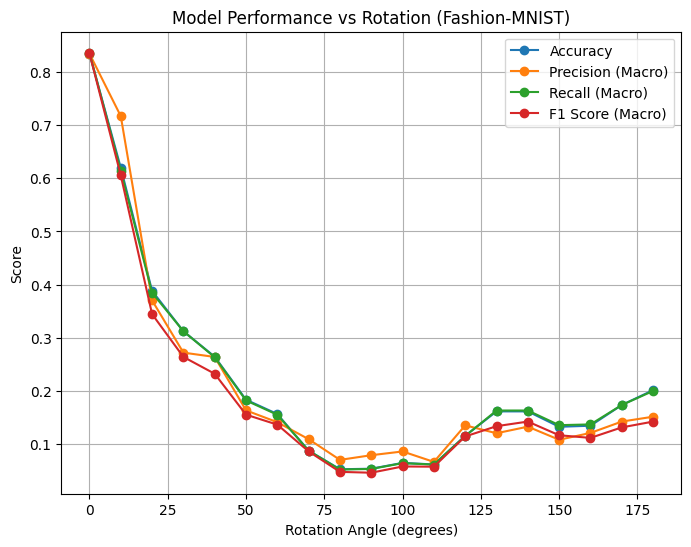

In [33]:
from scipy.ndimage import rotate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def rotate_single_image(flat_img, angle):
    """
    flat_img: shape (784,)
    angle: rotation in degrees
    """
    img = flat_img.reshape(28, 28)
    img_rot = rotate(img, angle, reshape=False)
    return img_rot.reshape(784)

def rotate_dataset(X, angle):
    return np.array([rotate_single_image(x, angle) for x in X])


angles = list(range(0, 181, 10))

accuracies = []
precisions = []
recalls = []
f1s = []

for angle in angles:
    print(f"Rotating by {angle} degrees...")

    # rotate test set
    X_rot = rotate_dataset(X_test, angle)

    # Apply PCA transform (same PCA object you trained earlier)
    X_rot_pca = pca.transform(X_rot)

    # Predict
    y_pred = model.predict(X_rot_pca)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

    print(f"Angle {angle:>3}° → Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")


plt.figure(figsize=(8, 6))

plt.plot(angles, accuracies, marker='o', label="Accuracy")
plt.plot(angles, precisions, marker='o', label="Precision (Macro)")
plt.plot(angles, recalls, marker='o', label="Recall (Macro)")
plt.plot(angles, f1s, marker='o', label="F1 Score (Macro)")

plt.xlabel("Rotation Angle (degrees)")
plt.ylabel("Score")
plt.title("Model Performance vs Rotation (Fashion-MNIST)")
plt.grid(True)
plt.legend()

# Save as vector graphic for LaTeX
plt.savefig("rotation_metrics_all.png", format="png")

plt.show()

###  Testing classification with Radial basis function to improve efficiecny. And playing around with various hyperparameters


In [34]:
# testing with RBF kernels just to see if we get better accuracy.( The accuracy is even bad)
class KMeans:
    def __init__(self, n_clusters=50, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        rng = np.random.default_rng(self.random_state)
        n_samples, n_features = X.shape

        # Initialize centers randomly
        idx = rng.choice(n_samples, self.n_clusters, replace=False)
        centers = X[idx].copy()

        for _ in range(self.max_iter):
            # Assign points to closest center
            dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
            labels = np.argmin(dists, axis=1)

            # Compute new centers
            new_centers = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else centers[i]
                                    for i in range(self.n_clusters)])

            # Check convergence
            if np.linalg.norm(new_centers - centers) < self.tol:
                break
            centers = new_centers

        self.cluster_centers_ = centers
        return self

class RBFTransformer:
    def __init__(self, n_centers=50, sigma=None, random_state=None):
        self.n_centers = n_centers
        self.sigma = sigma
        self.random_state = random_state

    def fit(self, X):
        # Compute centers with simple KMeans
        kmeans = KMeans(n_clusters=self.n_centers, random_state=self.random_state)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # sigma = median distance to nearest center
        dists = np.linalg.norm(X[:, None, :] - self.centers[None, :, :], axis=2)
        min_dists = np.min(dists, axis=1)
        if self.sigma is None:
            self.sigma = np.median(min_dists)

        return self

    def transform(self, X):
        dists = np.linalg.norm(X[:, None, :] - self.centers[None, :, :], axis=2)
        return np.exp(-dists**2 / (2 * self.sigma**2))

    def fit_transform(self, X):
        return self.fit(X).transform(X)

rbf = RBFTransformer(n_centers=10)
X_train_rbf = rbf.fit_transform(X_train)
X_test_rbf = rbf.transform(X_test)

model_rbf = LogisticRegression(lr=0.01, epochs=1000)
model_rbf.fit(X_train_rbf, y_train)
y_pred_rbf = model_rbf.predict(X_test_rbf)

accuracy_rbf = np.mean(y_pred_rbf == y_test)
print(f"RBF Kernel Accuracy: {accuracy_rbf:.4f}")


RBF Kernel Accuracy: 0.5990


In [41]:
# Evaluation Helpers + Label Names ===
# This cell defines reusable functions for:
#   (1) Computing model accuracy, precision, recall, and F1
#   (2) Printing per-class metrics in a clean, readable format
#   (3) Generating confusion matrix heatmaps
#
# These functions will be used across all evaluation experiments:
#   - baseline accuracy
#   - rotation robustness tests
#   - per-class recall drop analysis
#   - any additional real-world image tests

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)

# Human-readable Fashion-MNIST class names
FASHION_LABELS = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


def evaluate_predictions(y_true, y_pred, labels=None, model_name="Model"):
    """
    Compute and print classification metrics for a set of predictions.

    Parameters
    ----------
    y_true : array-like
        True class labels.
    y_pred : array-like
        Predicted class labels output by the model.
    labels : array-like or None
        Which label indices to include (default = unique labels in y_true).
    model_name : str
        A descriptive name printed in the evaluation header.

    Returns
    -------
    dict
        Contains accuracy, precision, recall, F1, support, and confusion matrix.
    """
    if labels is None:
        labels = np.unique(y_true)

    # Overall accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"=== {model_name} ===")
    print(f"Overall Accuracy: {acc:.4f}\n")

    # Per-class metrics (precision, recall, F1)
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )

    print("Per-class Metrics:")
    for idx, c in enumerate(labels):
        label_name = FASHION_LABELS[c] if c < len(FASHION_LABELS) else str(c)
        print(
            f"  Class {c:2d} ({label_name:12s}) | "
            f"Precision={prec[idx]:.3f}, Recall={rec[idx]:.3f}, "
            f"F1={f1[idx]:.3f}, Support={support[idx]}"
        )

    # Full scikit-learn classification report
    print("\nFull Classification Report:\n")
    print(classification_report(
        y_true, y_pred,
        target_names=FASHION_LABELS,
        digits=3
    ))

    # Confusion matrix for visualization
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Return metrics for later use
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "support": support,
        "labels": labels,
        "confusion_matrix": cm,
    }


def plot_confusion_matrix(cm, labels=None, title="Confusion Matrix"):
    """
    Display a confusion matrix heatmap.

    Parameters
    ----------
    cm : 2D numpy array
        Confusion matrix (shape = [n_classes, n_classes]).
    labels : list or None
        Tick label names (default = index numbers).
    title : str
        Title for the plot.
    """
    if labels is None:
        labels = np.arange(cm.shape[0])

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap="viridis")

    ax.set_title(title)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate x-axis tick labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Write confusion values into each cell
    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            ax.text(
                col, row, str(cm[row, col]),
                ha="center", va="center",
                color="white" if cm[row, col] > cm.max() * 0.6 else "black"
            )

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


In [ ]:
# Baseline Evaluation on Standard Fashion-MNIST Test Set ===
# This cell evaluates the performance of our RBF + Logistic Regression model
# on the unmodified Fashion-MNIST test dataset.
#
# It uses:
#   - y_pred_rbf (predictions from Cell 2)
#   - evaluate_predictions() (from Cell 1)
#   - plot_confusion_matrix() (from Cell 1)
#
# Outputs:
#   - Overall accuracy
#   - Per-class precision, recall, and F1
#   - Full classification report (scikit-learn style)
#   - Confusion matrix heatmap

metrics_rbf = evaluate_predictions(
    y_true=y_test,
    y_pred=y_pred_rbf,
    labels=np.arange(10),
    model_name="RBF Logistic Regression (Baseline Test Set)"
)

plot_confusion_matrix(
    metrics_rbf["confusion_matrix"],
    labels=np.arange(10),
    title="RBF Logistic Regression - Confusion Matrix (Baseline Test Set)"
)